# Set Covering Problem with Genetic Algorithm

In [1]:
import random
import logging
from numpy import linspace
from collections import Counter, namedtuple
from copy import copy
from matplotlib import pyplot as plt
import math
from functools import reduce
import pandas as pd

## Problem definition

In [2]:
def problem(N, seed=None):
    random.seed(seed)
    return [
        list(set(random.randint(0, N - 1) for n in range(random.randint(N // 5, N // 2))))
        for n in range(random.randint(N, N * 5))
    ]

## Useful functions

In [41]:
Individual = namedtuple('Individual',('genome','fitness'))
#Individual = one candidate solution with it's associated fitness
#genome = list/tuple of 0/1 that shows if a list in P=problem(N,seed) is taken or not
#fitness = weight associated to the solution

def initialize_population(N, P, population_size, problem_size, threshold=0): #by default start with empty solutions, can be changed
    population = list()
    for _ in range(population_size):
        genome=list()
        for __ in range(problem_size):
            if random.random() > threshold:
                genome.append(0)
            else: genome.append(1)
        genome=tuple(genome)
        population.append(Individual(genome,evaluate(N,P,genome)))
    return population

def evaluate(P,genome):
    solution = list()
    for i, el in enumerate(genome):
        if el == 1: solution.append(P[i])
    cnt=Counter()
    cnt.update(sum((e for e in solution), start=()))
    return len(cnt), -sum(len(el) for el in solution)

def tournament(population, tournament_size=2):
    return max(random.choices(population, k=tournament_size), key=lambda i: i.fitness)

def crossover(g1,g2,len_P):
    cut = random.randint(0, len_P)
    return g1.genome[:cut] + g2.genome[cut:]

#fusion operator from "A genetic algorithm for the set covering problem" by Beasley,Chu
def fusion(g1,g2,len_P):
    o = tuple()
    if g1.fitness[1] == 0 and g2.fitness[1] == 0: #if we are at the beginning we use the standard crossover function
        return crossover(g1,g2,len_P)
    prob = g2.fitness[1]/(g1.fitness[1] + g2.fitness[1])
    for el1,el2 in zip(g1.genome,g2.genome):
        if el1 == el2: o=o+(el1,)
        elif random.random() < prob: o=o+(el1,)
        else: o=o+(el2,)
    return o

def mutation(g,len_P):
    point = random.randint(0, len_P - 1)
    return g[:point] + (1 - g[point],) + g[point + 1 :]

def genome_to_solution(P,genome):
    solution = list()
    for i,el in enumerate(genome):
        if el == 1: solution.append(P[i])
    return solution

## Genetic Algorithm

In [30]:
def genetic_algorithm(
    N: int,
    P: list, 
    population_size: int,
    offspring_size: int,
    crossover_function=crossover,
    num_generations=1000,
    fixed=True
    ):
    
    #Variables initialization
    P = [tuple(_) for _ in P]
    problem_size = len(P)
    plateau_count = 0 #stores the number of consecutive generations in which the algorithm does not improve
    evaluate_count = 0 #stores the number of times the evaluate function is called
    random.seed(42)

    #Initialize population
    population = initialize_population(N, P, population_size, problem_size)
    
    #Create fitness log
    fitness_log = [(0, i.fitness) for i in population]

    prob_vett = [0.3,0.5,0.7]
    
    #Evolution algorithm
    for g in range(num_generations):
        offspring = list()
        for i in range(offspring_size):
            #decide the probability of crossover/mutation
            if fixed: prob=0.3
            elif g//10 > 2: #if fixed=False increase the probabiliy of mutation every 10 generations
                prob=0.7
            else: prob=prob_vett[g//10]
            if random.random() < prob:
                p = tournament(population)
                o = mutation(p.genome,problem_size)
            else:
                p1 = tournament(population)
                p2 = tournament(population)
                o = crossover_function(p1, p2, problem_size)
            f = evaluate(N, P, o)
            evaluate_count += 1
            fitness_log.append((g + 1, f))
            offspring.append(Individual(o, f))
        population += offspring
        population = sorted(population, key=lambda i: i.fitness, reverse=True)[:population_size]
        
        #check if we have reached a plateau, if we don't improve for 30 generations break
        if max(f[1] for f in fitness_log if f[0] == g + 1) <= max(f[1] for f in fitness_log if f[0] == g): plateau_count += 1
        else: plateau_count = 0
        if plateau_count == 30: break 

    if population[0].fitness[0] == N: logging.debug(f' Solution found for N={N}: w={population[0].fitness} (bloat={int((-population[0].fitness[1]-N)*100/N)}%) after {g + 1} generations. Evaluate called {evaluate_count} times.')
    else: logging.debug('Could not find a valid solution, increase the number of generations.')

    return population[0], fitness_log, g+1

## Population and Offspring size tuning

### One point crossover, fixed crossover/mutation probability

In [112]:
logging.getLogger().setLevel(logging.INFO)
all = list()
SEED = 42

for N in [5, 10, 20, 100, 500, 1000]:
    best = None
    for population_coefficient in linspace(1, 2.5, 6):
        population_size = math.ceil(population_coefficient * N)
        for offspring_coefficient in linspace(0.3, 2, 6):
            random.seed(42) #set the seed here to guarantee reproducible results outside of this for loops
            offspring_size = math.ceil(offspring_coefficient * population_size)
            _, fitness_log, generations = genetic_algorithm(N,problem(N,SEED), crossover_function=crossover, population_size=population_size, offspring_size=offspring_size)
            if best is None or max(f[1] for f in fitness_log if f[0] == generations) > best[0]:
                best = (max(f[1] for f in fitness_log if f[0] == generations), (population_coefficient, offspring_coefficient), generations)
            all.append((N, population_coefficient, offspring_coefficient, max(f[1] for f in fitness_log if f[0] == generations), generations))
    logging.info(f'Best solution found for N = {N}: {best[0]} with population_size={ math.ceil(best[1][0]*N)} and offspring_size={ math.ceil(best[1][0]*N*best[1][1])} after {best[2]} generations.')

DEBUG:root:Best solution found for N = 5: (5, -5) with population_size=5 and offspring_size=9 after 41 generations.
DEBUG:root:Best solution found for N = 10: (10, -10) with population_size=13 and offspring_size=22 after 35 generations.
DEBUG:root:Best solution found for N = 20: (20, -25) with population_size=38 and offspring_size=38 after 42 generations.
DEBUG:root:Best solution found for N = 100: (100, -183) with population_size=250 and offspring_size=415 after 42 generations.
DEBUG:root:Best solution found for N = 500: (500, -1260) with population_size=1100 and offspring_size=2200 after 57 generations.
DEBUG:root:Best solution found for N = 1000: (1000, -3439) with population_size=2500 and offspring_size=3300 after 79 generations.


### One point crossover, variable crossover/mutation probability

In [22]:
logging.getLogger().setLevel(logging.INFO)
all = list()
SEED = 42

for N in [5, 10, 20, 100, 500, 1000]:
    best = None
    for population_coefficient in linspace(1, 2.5, 6):
        population_size = math.ceil(population_coefficient * N)
        for offspring_coefficient in linspace(0.3, 2, 6):
            random.seed(42) #set the seed here to guarantee reproducible results outside of this for loops
            offspring_size = math.ceil(offspring_coefficient * population_size)
            _, fitness_log, generations = genetic_algorithm(N,problem(N,SEED), crossover_function=crossover, population_size=population_size, offspring_size=offspring_size)
            if best is None or max(f[1] for f in fitness_log if f[0] == generations) > best[0]:
                best = (max(f[1] for f in fitness_log if f[0] == generations), (population_coefficient, offspring_coefficient), generations)
            all.append((N, population_coefficient, offspring_coefficient, max(f[1] for f in fitness_log if f[0] == generations), generations))
    logging.info(f'Best solution found for N = {N}: {best[0]} with population_size={ math.ceil(best[1][0]*N)} and offspring_size={ math.ceil(best[1][0]*N*best[1][1])} after {best[2]} generations.')

INFO:root:Best solution found for N = 5: (5, -5) with population_size=5 and offspring_size=10 after 40 generations.
INFO:root:Best solution found for N = 10: (10, -10) with population_size=13 and offspring_size=22 after 35 generations.
INFO:root:Best solution found for N = 20: (20, -23) with population_size=44 and offspring_size=14 after 90 generations.
INFO:root:Best solution found for N = 100: (100, -183) with population_size=221 and offspring_size=66 after 97 generations.
INFO:root:Best solution found for N = 500: (500, -1442) with population_size=1100 and offspring_size=1078 after 62 generations.
INFO:root:Best solution found for N = 1000: (1000, -3400) with population_size=2500 and offspring_size=3300 after 84 generations.


### Fusion crossover, fixed crossover/mutation probability

In [ ]:
#computationally very expensive, obtains results comparable with those found with the "standard" crossover
logging.getLogger().setLevel(logging.INFO)
SEED = 42
all = list()
SEED = 42

for N in [5, 10, 20, 100]:
    best = None
    for population_coefficient in linspace(1, 2.5, 6):
        population_size = math.ceil(population_coefficient * N)
        for offspring_coefficient in linspace(0.3, 2, 6):
            random.seed(42) #set the seed here to guarantee reproducible results outside of this for loops
            offspring_size = math.ceil(offspring_coefficient * population_size)
            _, fitness_log, generations = genetic_algorithm(N,problem(N,SEED), crossover_function=fusion, population_size=population_size, offspring_size=offspring_size)
            if best is None or max(f[1] for f in fitness_log if f[0] == generations) > best[0]:
                best = (max(f[1] for f in fitness_log if f[0] == generations), (population_coefficient, offspring_coefficient), generations)
            all.append((N, population_coefficient, offspring_coefficient, max(f[1] for f in fitness_log if f[0] == generations), generations))
    logging.info(f'Best solution found for N = {N}: {best[0]} with population_size={ math.ceil(best[1][0]*N)} and offspring_size={ math.ceil(best[1][0]*N*best[1][1])} after {best[2]} generations.')

INFO:root:Best solution found for N = 5: (5, -5) with population_size=5 and offspring_size=2 after 133 generations.
INFO:root:Best solution found for N = 10: (10, -10) with population_size=19 and offspring_size=13 after 44 generations.
INFO:root:Best solution found for N = 20: (20, -24) with population_size=38 and offspring_size=76 after 39 generations.
INFO:root:Best solution found for N = 100: (100, -187) with population_size=190 and offspring_size=380 after 46 generations.


## Results

- population_size = 2*N  
- offspring_size = N  
- standard crossover  
- fixed crossover/mutation probability  
- plateau check (stops after 30 generations with no improvment, max 1000 generations)  

`INFO:root: Solution found for N=5: w=(5, -5) (bloat=0%) after 33 generations.`  
`INFO:root: Solution found for N=10: w=(10, -10) (bloat=0%) after 44 generations.`  
`INFO:root: Solution found for N=20: w=(20, -24) (bloat=20%) after 43 generations.`  
`INFO:root: Solution found for N=100: w=(100, -203) (bloat=103%) after 82 generations.`  
`INFO:root: Solution found for N=500: w=(500, -1596) (bloat=219%) after 81 generations.`  
`INFO:root: Solution found for N=1000: w=(1000, -3736) (bloat=273%) after 83 generations.`  

- population_size = 2*N  
- offspring_size = N  
- fusion_crossover  
- fixed crossover/mutation probability  
- with plateau check (stops after 30 generations with no improvment, max 1000 generations)   

`INFO:root: Solution found for N=5: w=(5, -5) (bloat=0%) after 34 generations.`  
`INFO:root: Solution found for N=10: w=(10, -10) (bloat=0%) after 40 generations.`  
`INFO:root: Solution found for N=20: w=(20, -24) (bloat=20%) after 50 generations.`  
`INFO:root: Solution found for N=100: w=(100, -205) (bloat=105%) after 119 generations.`  
`INFO:root: Solution found for N=500: w=(500, -1724) (bloat=244%) after 98 generations.`  
`INFO:root: Solution found for N=1000: w=(1000, -3912) (bloat=291%) after 113 generations.`  

- standard crossover  
- with plateau check (stops after 30 generations with no improvment, max 1000 generations)  
- fixed crossover/mutation probability  
- *with population_size and offspring_size tuning*  

`DEBUG:root:Best solution found for N = 5: (5, -5) with population_size=5 and offspring_size=9 after 41 generations.`  
`DEBUG:root:Best solution found for N = 10: (10, -10) with population_size=13 and offspring_size=22 after 35 generations.`  
`DEBUG:root:Best solution found for N = 20: (20, -25) with population_size=38 and offspring_size=38 after 42 generations.`  
`DEBUG:root:Best solution found for N = 100: (100, -183) with population_size=250 and offspring_size=415 after 42 generations.`  
`DEBUG:root:Best solution found for N = 500: (500, -1260) with population_size=1100 and offspring_size=2200 after 57 generations.`  
`DEBUG:root:Best solution found for N = 1000: (1000, -3439) with population_size=2500 and offspring_size=3300 after 79 generations.`  

- standard crossover  
- with plateau check (stops after 30 generations with no improvment, max 1000 generations)  
- variable crossover/mutation probability  
- *with population_size and offspring_size tuning*  
`DEBUG:root: Solution found for N=5: w=(5, -5) (bloat=0%) after 40 generations. Evaluate called 400 times.`  
`DEBUG:root: Solution found for N=10: w=(10, -10) (bloat=0%) after 35 generations. Evaluate called 770 times.`  
`DEBUG:root: Solution found for N=20: w=(20, -23) (bloat=15%) after 90 generations. Evaluate called 1260 times.`  
`DEBUG:root: Solution found for N=100: w=(100, -183) (bloat=83%) after 43 generations. Evaluate called 17845 times.`  
`DEBUG:root: Solution found for N=500: w=(500, -1442) (bloat=188%) after 62 generations. Evaluate called 66836 times.`  
`DEBUG:root: Solution found for N=1000: w=(1000, -3400) (bloat=240%) after 84 generations. Evaluate called 277200 times.`  

## Reproduce and visualize results

In [180]:
# Results obtained using tuned population and offspring size with standard crossover and fixed=True
# It's worth to notice that for almost all Ns the best results are obtained when the offspring size is bigger than the population size
SEED = 42
N = [5, 10, 20, 100, 500, 1000]
pop_off = [(5,9),(13,22),(38,38),(250,415),(1100,2200),(2500,3300)]
d = dict(zip(N,pop_off))
logging.getLogger().setLevel(logging.DEBUG)
for el in d.keys():
    random.seed(42)
    sol,fitness_log,gen=genetic_algorithm(el,problem(el,SEED), population_size=d[el][0], offspring_size=d[el][1], crossover_function=crossover)

DEBUG:root: Solution found for N=5: w=(5, -5) (bloat=0%) after 41 generations. Evaluate called 369 times.
DEBUG:root: Solution found for N=10: w=(10, -10) (bloat=0%) after 35 generations. Evaluate called 770 times.
DEBUG:root: Solution found for N=20: w=(20, -25) (bloat=25%) after 42 generations. Evaluate called 1596 times.
DEBUG:root: Solution found for N=100: w=(100, -183) (bloat=83%) after 42 generations. Evaluate called 17430 times.
DEBUG:root: Solution found for N=500: w=(500, -1260) (bloat=152%) after 57 generations. Evaluate called 125400 times.
DEBUG:root: Solution found for N=1000: w=(1000, -3439) (bloat=243%) after 79 generations. Evaluate called 260700 times.


In [39]:
# Results obtained using tuned population and offspring size with standard crossover and fixed=False
# It's worth to notice that for almost all Ns the best results are obtained when the offspring size is bigger than the population size
SEED = 42
N = [5, 10, 20, 100, 500, 1000]
pop_off = [(5,10),(13,22),(44,14),(250,415),(1100,1078),(2500,3300)]
d = dict(zip(N,pop_off))
logging.getLogger().setLevel(logging.DEBUG)
for el in d.keys():
    random.seed(42)
    sol,fitness_log,gen=genetic_algorithm(el,problem(el,SEED), population_size=d[el][0], offspring_size=d[el][1], crossover_function=crossover, fixed=False)

DEBUG:root: Solution found for N=5: w=(5, -5) (bloat=0%) after 40 generations. Evaluate called 400 times.
DEBUG:root: Solution found for N=10: w=(10, -10) (bloat=0%) after 35 generations. Evaluate called 770 times.
DEBUG:root: Solution found for N=20: w=(20, -23) (bloat=15%) after 90 generations. Evaluate called 1260 times.
DEBUG:root: Solution found for N=100: w=(100, -183) (bloat=83%) after 43 generations. Evaluate called 17845 times.
DEBUG:root: Solution found for N=500: w=(500, -1442) (bloat=188%) after 62 generations. Evaluate called 66836 times.
DEBUG:root: Solution found for N=1000: w=(1000, -3400) (bloat=240%) after 84 generations. Evaluate called 277200 times.


In [182]:
# Results obtained with population_size=2*N and offspring_size=N
SEED = 42
N = [5, 10, 20, 100, 500, 1000]
logging.getLogger().setLevel(logging.DEBUG)
for n in N:
    random.seed(42)
    sol,fitness_log,gen=genetic_algorithm(n,problem(n,SEED), population_size=2*n, offspring_size=n, crossover_function=crossover)

DEBUG:root: Solution found for N=5: w=(5, -6) (bloat=20%) after 45 generations. Evaluate called 225 times.
DEBUG:root: Solution found for N=10: w=(10, -10) (bloat=0%) after 47 generations. Evaluate called 470 times.
DEBUG:root: Solution found for N=20: w=(20, -33) (bloat=65%) after 38 generations. Evaluate called 760 times.
DEBUG:root: Solution found for N=100: w=(100, -207) (bloat=107%) after 88 generations. Evaluate called 8800 times.
DEBUG:root: Solution found for N=500: w=(500, -1615) (bloat=223%) after 75 generations. Evaluate called 37500 times.
DEBUG:root: Solution found for N=1000: w=(1000, -3459) (bloat=245%) after 113 generations. Evaluate called 113000 times.


DEBUG:root: Solution found for N=100: w=(100, -183) (bloat=83%) after 42 generations. Evaluate called 17430 times.


[[1, 2, 5, 6, 11, 13, 17, 27, 30, 33, 36, 39, 45, 46, 50, 51, 55, 58, 59, 60, 63, 64, 65, 68, 74, 76, 83, 86, 93, 97], [0, 1, 8, 9, 11, 12, 13, 15, 16, 17, 18, 27, 28, 29, 38, 40, 43, 47, 48, 49, 54, 56, 61, 66, 67, 72, 75, 82, 86, 87, 88, 89, 93, 96, 99], [1, 4, 7, 11, 14, 16, 17, 20, 21, 22, 24, 25, 27, 28, 29, 34, 35, 37, 42, 43, 45, 47, 49, 52, 53, 58, 59, 60, 62, 66, 70, 72, 73, 75, 77, 78, 80, 81, 88, 92, 93, 97], [0, 6, 15, 29, 30, 36, 38, 43, 44, 45, 57, 58, 64, 68, 72, 73, 74, 76, 80, 83, 85, 91, 94, 95, 96], [0, 4, 5, 10, 11, 15, 16, 17, 20, 21, 23, 26, 31, 32, 37, 38, 40, 46, 54, 56, 57, 64, 66, 68, 69, 71, 73, 76, 83, 84, 88, 96], [1, 3, 11, 19, 20, 26, 33, 41, 50, 55, 69, 70, 73, 75, 79, 80, 90, 97, 98]]


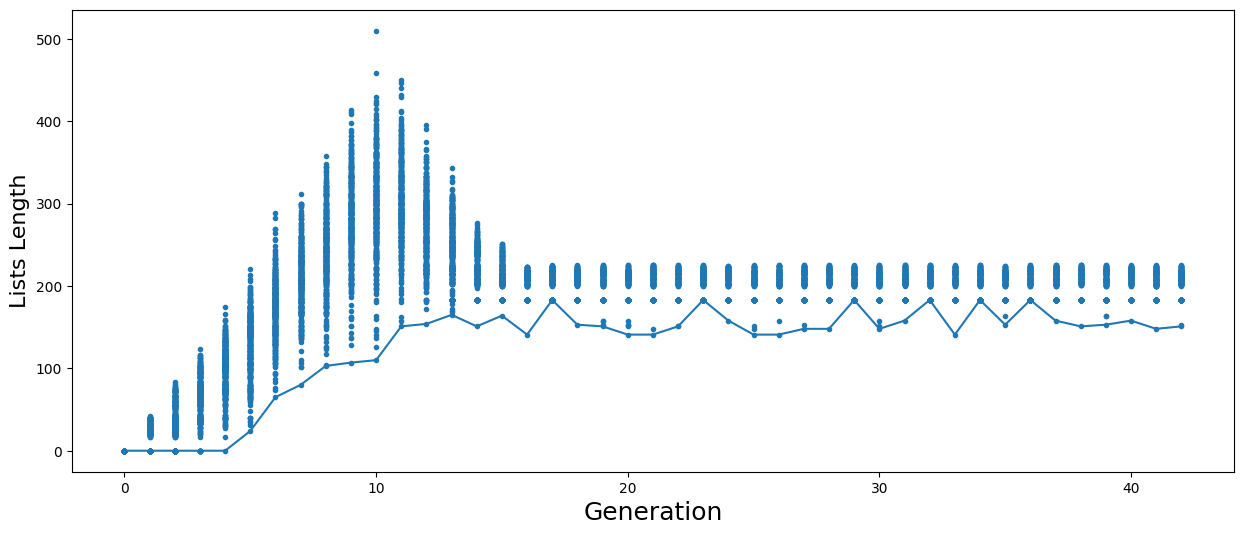

In [7]:
#Explicit soution and plot for N=100, population_size=250 and offspring_size=415
SEED=42
N=100
random.seed(SEED)
logging.getLogger().setLevel(logging.DEBUG)
sol,fitness_log,gen=genetic_algorithm(N,problem(N,SEED), population_size=250, offspring_size=415, crossover_function=crossover)
print(genome_to_solution(problem(N,SEED),sol.genome))
x = [x for x, _ in fitness_log]
y = [-y[1] for _, y in fitness_log]
df = pd.DataFrame(x, columns=['x'])
df['y'] = y
df = df.groupby('x').min()
plt.figure(figsize=(15, 6))
plt.xlabel('Generation', fontsize=18)
plt.ylabel('Lists Length', fontsize=16)
plt.scatter([x for x, _ in fitness_log], [-y[1] for _, y in fitness_log], marker=".")
plt.plot(df.index, df['y'])